In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm
import copy

import gpytorch
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import george
from george import kernels

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import treegp

from lsst.meas.algorithms import CloughTocher2DInterpolatorUtils as ctUtils

%matplotlib widget

In [2]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect

        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print("time for %s = %.4f" % (fname, t1 - t0))
        return result

    return f2

In [3]:
dic = pickle.load(open("data/out_test_0", "rb"))
maskedImage = dic['in']['maskedImage']

In [12]:
class GPRegressionModelEXACT(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModelEXACT, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class gp_torch():

    #@timer
    def __init__(self, std=15., correlation_length=3000., white_noise=1., mean=0.):
    
        self.hypers = {
            'likelihood.noise_covar.noise': torch.tensor(white_noise, dtype=torch.float32),
            'covar_module.base_kernel.lengthscale': torch.tensor(correlation_length, dtype=torch.float32),
            'covar_module.outputscale': torch.tensor(std, dtype=torch.float32),
            'mean_module.constant': torch.tensor(mean, dtype=torch.float32),
        }

    #@timer
    def fit(self, x, y):
        
        X = torch.tensor(x, dtype=torch.float32)
        Y = torch.tensor(y, dtype=torch.float32)

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = GPRegressionModelEXACT(X, Y, self.likelihood)
        self.model.initialize(**self.hypers)
        self.model.eval()
        self.likelihood.eval()

    #@timer
    def predict(self, x):
        X = torch.tensor(x, dtype=torch.float32)
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            prediction = self.likelihood(self.model(X))
            y_predict = prediction.mean
        return y_predict.numpy()



class GaussianProcessHODLRSolver():

    def __init__(self, variance=1., correlation_length=1., white_noise=0., mean=0., HODLRSolver=True):
        
        self.variance = variance
        self.correlation_length = correlation_length
        self.white_noise  = white_noise
        self.mean = mean
        self.HODLRSolver = HODLRSolver

    # @timer
    def fit(self, x_good):
        kernel = self.variance * kernels.ExpSquaredKernel(self.correlation_length, ndim=2)
        if self.HODLRSolver: 
            self.gp = george.GP(kernel, mean=self.mean,
                                fit_kernel=False,
                                solver=george.HODLRSolver, seed=42, tol=0.001,
                                min_size=100)
        else:
            self.gp = george.GP(kernel, mean=self.mean,
                                fit_kernel=False)
        self.gp.compute(x_good, yerr=self.white_noise)

    # @timer
    def predict(self, x_bad, y_good):
        y_pred = self.gp.predict(y_good, x_bad, return_var=False, return_cov=False)
        return y_pred


class gp_sklearn():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):

        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    def fit(self, x, y):
        alpha = self.white_noise**2
        self.kernel = self.std**2 * RBF(length_scale=self.l)
        self.gp =  GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, optimizer=None)
        self.gp.fit(x, y)

    def predict(self, x):
        y_pred = self.gp
        return y_pred


class gp_treegp():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
        
        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise


    # @timer
    def fit(self, x, y):
        # alpha = self.white_noise**2
        # kernel = self.std**2 * kernels.ExpSquaredKernel(self.l, ndim=2)
        # self.gp = george.GP(kernel, fit_kernel=False, solver=george.HODLRSolver, seed=42)
        # self.gp.compute(x, yerr=alpha)
        # self._y = y

        KERNEL = '%.2f**2 * RBF(%f)'%((self.std, self.l))
        self.gp = treegp.GPInterpolation(
                kernel=KERNEL,
                optimizer='none',
                normalize=True,
                p0=[3000.0, 0.0, 0.0],
                white_noise=self.white_noise,
        )
        self.gp.initialize(x, y)
        self.gp.solve()

    # @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred    
        

class InterpolateOverDefectGaussianProcess():

    @timer
    def __init__(self, maskedImage, defects=["BAD", "SAT", "CR", "EDGE"], fwhm=5, block_size=100, use_treegp=True, 
                 use_george=False, HODLRSolver=True):

        if use_treegp and use_george:
            raise ValueError("need to use treegp solver or george")
        if use_treegp:
            self.use_treegp = True
        else:
            self.use_treegp = False

        self.HODLRSolver = HODLRSolver

        self.maskedImage = maskedImage
        self.defects = defects

        # Define hyperparameters for GPs.
        # Kernel would be isotropic RBF (simple / agnostic choice)
        # Amplitude of the kernel would be variance observed on the image.
        # Correlation lenght would be PSF size.
        # White noise would be standard deviation of the variance map.
        # Mean would be set to the mean in the whole CCD.
        # In order to do processing fast, sub-divide GP computation on a block.
        # Block shape is block_size * block_size

        # TO DO: compute the value only on good pixel
        # TO DO: deal with not good value?
        self.correlation_length = fwhm
        # self.white_noise = np.sqrt(np.mean(maskedImage.getVariance().array))
        # self.kernel_amplitude = np.var(maskedImage.getImage().array) - self.white_noise**2
        # self.mean = np.mean(maskedImage.getImage().array)
        self.block_size = block_size
        self.dic = {'IN': copy.deepcopy(self.maskedImage),
                    'OUT':{}}
        self.I = 0

    @timer
    def interpolate_over_defects(self):

        nx = self.maskedImage.getDimensions()[0]
        ny = self.maskedImage.getDimensions()[1]
        for x in tqdm(range(0, nx, self.block_size)):
            for y in range(0, ny, self.block_size):
                sub_nx = min(self.block_size, nx - x)
                sub_ny = min(self.block_size, ny - y)
                sub_masked_image = self.maskedImage[x:x+sub_nx, y:y+sub_ny]
                self.dic['OUT'].update({self.I: {
                    "lim": [[x,x+sub_nx], [y,y+sub_ny]],
                    "sub_masked_image_in": copy.deepcopy(sub_masked_image),
                    "GP": {},
                }})
                sub_masked_image = self.interpolate_sub_masked_image(sub_masked_image, treegp=self.use_treegp)
                self.maskedImage[x:x+sub_nx, y:y+sub_ny] = sub_masked_image
                self.I += 1


    # @timer
    def interpolate_sub_masked_image(self, sub_masked_image, treegp=True):
        

        cut = self.correlation_length * 5
        bad_pixel, good_pixel = ctUtils.findGoodPixelsAroundBadPixels(sub_masked_image, self.defects, buffer=cut)
        # Do nothing if bad pixel is None.
        if np.shape(bad_pixel)[0] == 0:
            return sub_masked_image
        # Do GP interpolation if bad pixel found.
        else:
            # gp interpolation
            mean = np.mean(good_pixel[:,2:])
            white_noise = np.sqrt(np.mean(sub_masked_image.getVariance().array))
            kernel_amplitude = np.var(good_pixel[:,2:]) #- white_noise**2

            if not treegp:
                gp_hodlr = GaussianProcessHODLRSolver(variance=kernel_amplitude, correlation_length=self.correlation_length,
                                                      white_noise=white_noise, mean=mean, HODLRSolver=self.HODLRSolver)
                gp_hodlr.fit(good_pixel[:,:2])
                gp_predict = gp_hodlr.predict(bad_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
            else:
                gpt = gp_treegp(std=np.sqrt(kernel_amplitude), correlation_length=self.correlation_length, white_noise=white_noise)
                gpt.fit(good_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
                gp_predict = gpt.predict(bad_pixel[:,:2])
            bad_pixel[:,2:] = gp_predict.reshape(np.shape(bad_pixel[:,2:]))

            # update_value
            ctUtils.updateImageFromArray(sub_masked_image.image, bad_pixel)
            self.dic['OUT'][self.I]["GP"].update({"bad":bad_pixel,
                                                 "good": good_pixel,
                                                 "interpolated": copy.deepcopy(sub_masked_image)})
            return sub_masked_image


class InterpolateOverDefectGaussianProcessTorch():

    @timer
    def __init__(self, maskedImage, defects=["BAD", "SAT", "CR", "EDGE"], fwhm=5, block_size=100, use_treegp=True, 
                 use_torch=False):

        if use_treegp and use_torch:
            raise ValueError("need to use treegp solver or george")
        if use_treegp:
            self.use_treegp = True
        else:
            self.use_treegp = False

        self.maskedImage = maskedImage
        self.defects = defects

        # Define hyperparameters for GPs.
        # Kernel would be isotropic RBF (simple / agnostic choice)
        # Amplitude of the kernel would be variance observed on the image.
        # Correlation lenght would be PSF size.
        # White noise would be standard deviation of the variance map.
        # Mean would be set to the mean in the whole CCD.
        # In order to do processing fast, sub-divide GP computation on a block.
        # Block shape is block_size * block_size

        # TO DO: compute the value only on good pixel
        # TO DO: deal with not good value?
        self.correlation_length = fwhm
        # self.white_noise = np.sqrt(np.mean(maskedImage.getVariance().array))
        # self.kernel_amplitude = np.var(maskedImage.getImage().array) - self.white_noise**2
        # self.mean = np.mean(maskedImage.getImage().array)
        self.block_size = block_size
        self.dic = {'IN': copy.deepcopy(self.maskedImage),
                    'OUT':{}}
        self.I = 0

    @timer
    def interpolate_over_defects(self):

        nx = self.maskedImage.getDimensions()[0]
        ny = self.maskedImage.getDimensions()[1]
        for x in tqdm(range(0, nx, self.block_size)):
            for y in range(0, ny, self.block_size):
                sub_nx = min(self.block_size, nx - x)
                sub_ny = min(self.block_size, ny - y)
                sub_masked_image = self.maskedImage[x:x+sub_nx, y:y+sub_ny]
                self.dic['OUT'].update({self.I: {
                    "lim": [[x,x+sub_nx], [y,y+sub_ny]],
                    "sub_masked_image_in": copy.deepcopy(sub_masked_image),
                    "GP": {},
                }})
                sub_masked_image = self.interpolate_sub_masked_image(sub_masked_image, treegp=self.use_treegp)
                self.maskedImage[x:x+sub_nx, y:y+sub_ny] = sub_masked_image
                self.I += 1


    # @timer
    def interpolate_sub_masked_image(self, sub_masked_image, treegp=True):
        

        cut = self.correlation_length * 5
        bad_pixel, good_pixel = ctUtils.findGoodPixelsAroundBadPixels(sub_masked_image, self.defects, buffer=cut)
        # Do nothing if bad pixel is None.
        if np.shape(bad_pixel)[0] == 0:
            return sub_masked_image
        # Do GP interpolation if bad pixel found.
        else:
            # gp interpolation
            mean = np.mean(good_pixel[:,2:])
            white_noise = np.sqrt(np.mean(sub_masked_image.getVariance().array))
            kernel_amplitude = np.var(good_pixel[:,2:]) #- white_noise**2

            if not treegp:
                gpt = gp_torch(std=np.sqrt(kernel_amplitude), correlation_length=self.correlation_length, white_noise=white_noise, mean=mean)
                gpt.fit(good_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
                gp_predict = gpt.predict(bad_pixel[:,:2])
            else:
                gpt = gp_treegp(std=np.sqrt(kernel_amplitude), correlation_length=self.correlation_length, white_noise=white_noise)
                gpt.fit(good_pixel[:,:2], np.squeeze(good_pixel[:,2:]))
                gp_predict = gpt.predict(bad_pixel[:,:2])

            bad_pixel[:,2:] = gp_predict.reshape(np.shape(bad_pixel[:,2:]))

            # update_value
            ctUtils.updateImageFromArray(sub_masked_image.image, bad_pixel)
            self.dic['OUT'][self.I]["GP"].update({"bad":bad_pixel,
                                                 "good": good_pixel,
                                                 "interpolated": copy.deepcopy(sub_masked_image)})
            return sub_masked_image

time for InterpolateOverDefectGaussianProcessTorch.__init__ = 0.0147


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


time for InterpolateOverDefectGaussianProcessTorch.interpolate_over_defects = 27.0157


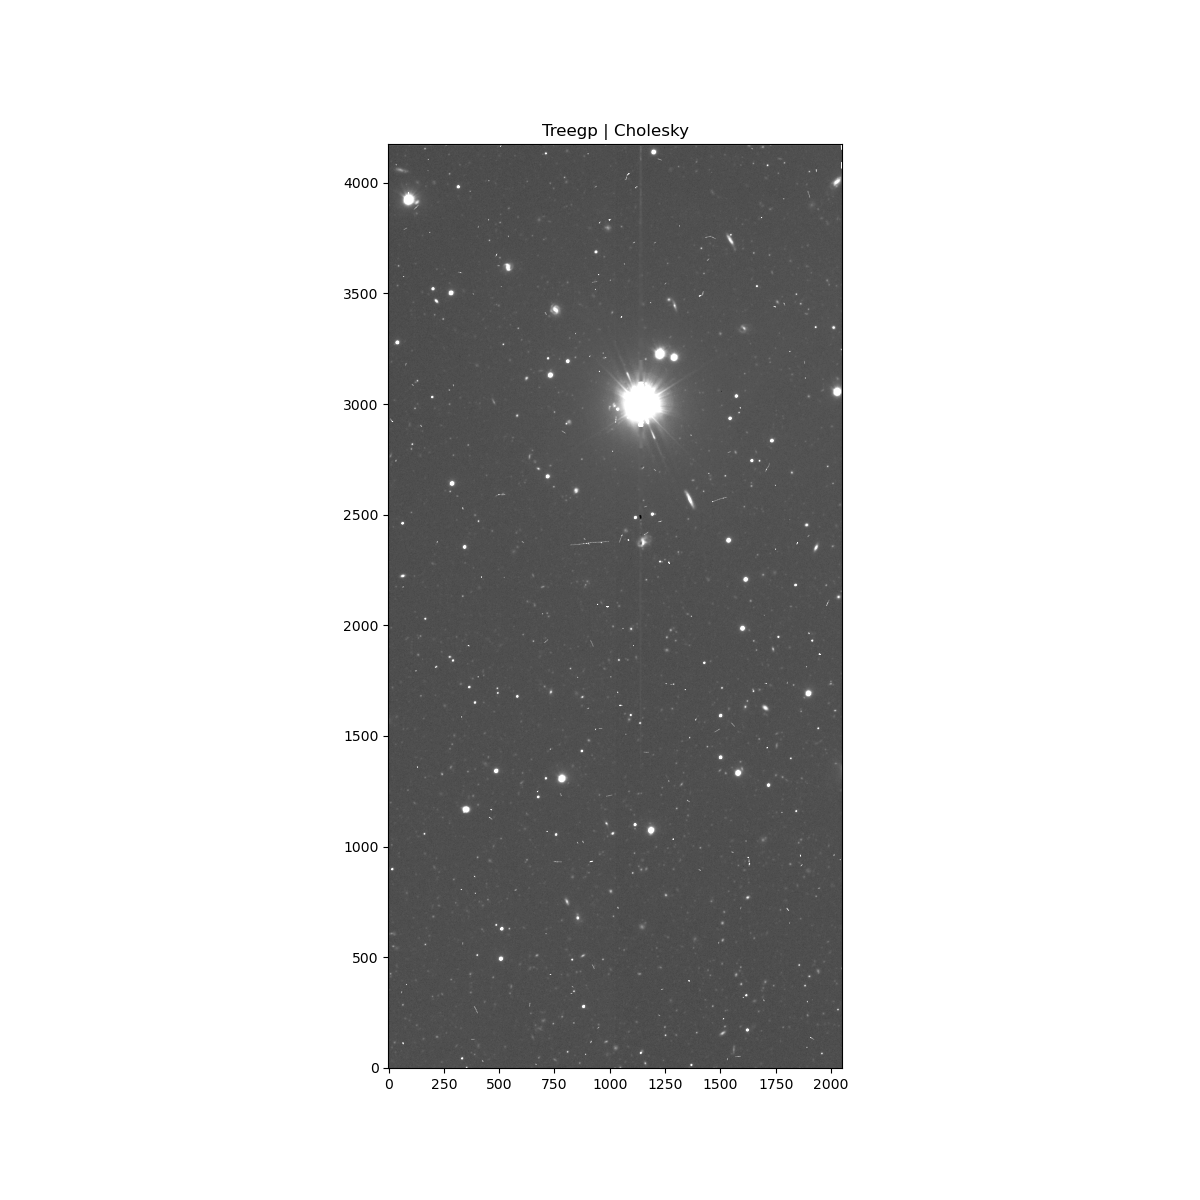

In [16]:
to_interpolate = copy.deepcopy(maskedImage)
GP = InterpolateOverDefectGaussianProcessTorch(to_interpolate, defects=["SAT"], fwhm=5, block_size=100, use_treegp=True, use_torch=False,)
GP.interpolate_over_defects()

plt.figure(figsize=(12, 12))
plt.imshow(GP.maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()
plt.title('Treegp | Cholesky')
plt.savefig('1_treegp_cholesky_box_interp.png')

time for InterpolateOverDefectGaussianProcessTorch.__init__ = 0.0124


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]

time for InterpolateOverDefectGaussianProcessTorch.interpolate_over_defects = 22.0074


Text(0.5, 1.0, 'Torch')

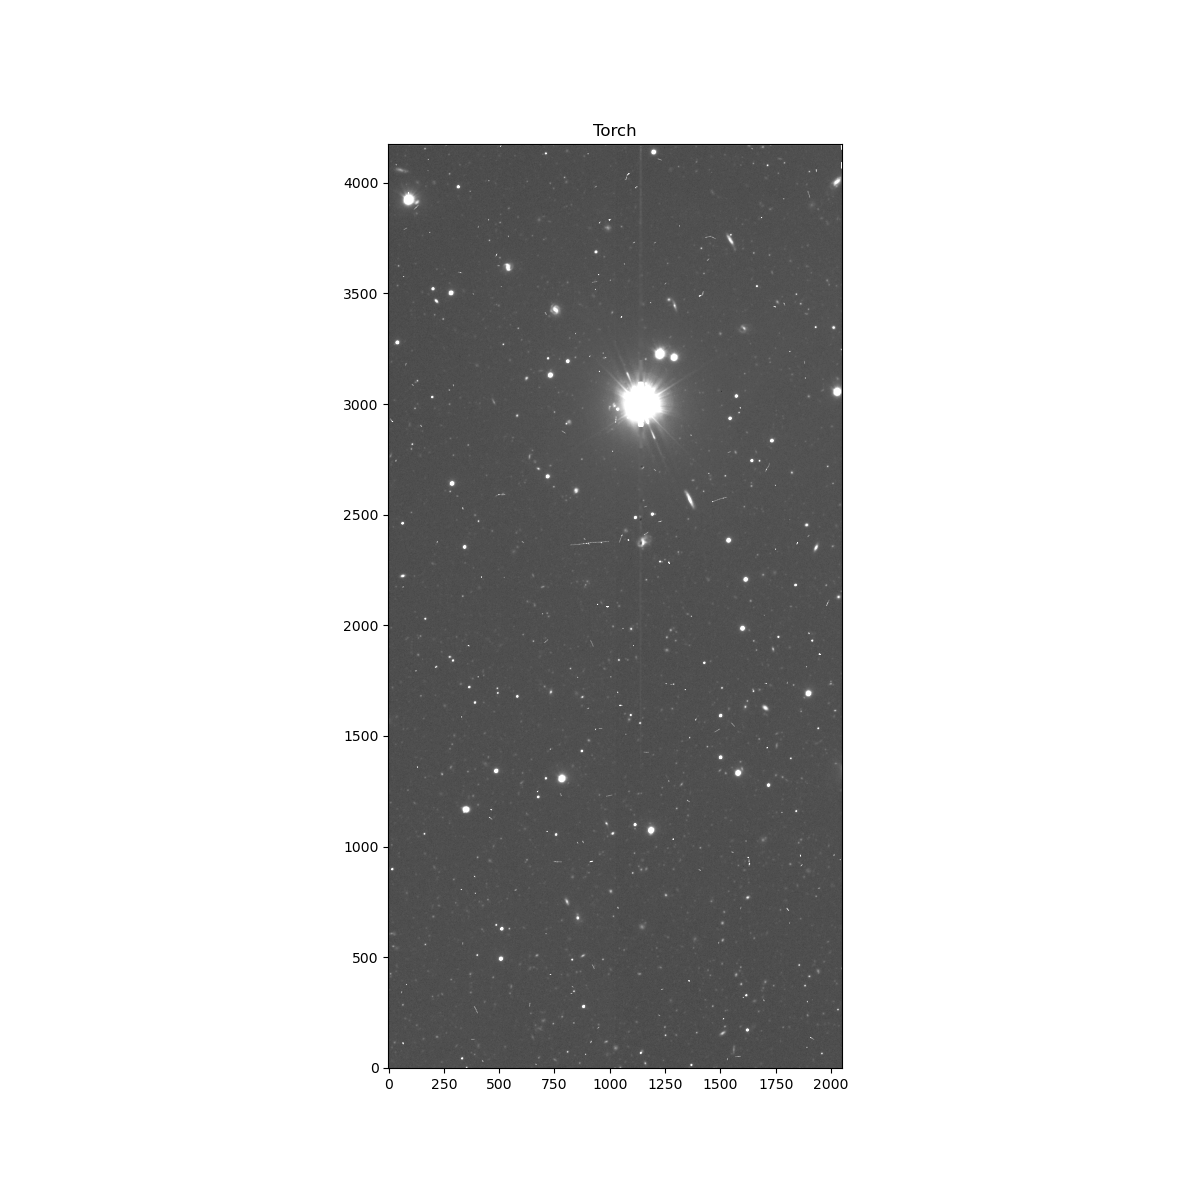

In [15]:
to_interpolate = copy.deepcopy(maskedImage)
GP = InterpolateOverDefectGaussianProcessTorch(to_interpolate, defects=["SAT"], fwhm=5, block_size=100, use_treegp=False, use_torch=True)
GP.interpolate_over_defects()

plt.figure(figsize=(12, 12))
plt.imshow(GP.maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()
plt.title('Torch')
#plt.savefig('test_torch')

In [16]:
# GP.dic
import pickle
pkl = open('animation_box_gp_holdr.pkl', 'wb')
pickle.dump(GP.dic, pkl)
pkl.close()

In [ ]:
to_interpolate = copy.deepcopy(maskedImage)
GP = InterpolateOverDefectGaussianProcess(to_interpolate, defects=["SAT"], fwhm=5, block_size=40, use_treegp=False, use_george=True, HODLRSolver=True)
GP.interpolate_over_defects()

plt.figure(figsize=(12, 12))
plt.imshow(GP.maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()
plt.title('George | HODLR')
plt.savefig('3_george_HODLR_box_interp.png')

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
#plt.imshow(GP.maskedImage.getImage().array, norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()
plt.title('Raw | no interp')
plt.savefig('0_no_interp.png')

In [ ]:
to_interpolate = copy.deepcopy(maskedImage)
GP = InterpolateOverDefectGaussianProcess(to_interpolate, defects=["SAT", "CR", "EDGE"], fwhm=15, block_size=40, use_treegp=False, use_george=True, HODLRSolver=True)
GP.interpolate_over_defects()

plt.figure(figsize=(12, 12))
plt.imshow(GP.maskedImage.getImage().array, vmin=400, vmax=800, cmap=plt.cm.Greys_r)
plt.gca().invert_yaxis()
plt.title('George | HODLR')
plt.savefig('3_george_HODLR_box_interp.png')